In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import os

In [2]:
data_dir = 'Data/Bootside'

In [3]:
batch_size = 32
img_height = 200
img_width = 200

In [4]:
tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=32,
image_size=(256, 256),
shuffle=True,
seed=None,
validation_split=None,
subset=None,
interpolation="bilinear",
follow_links=False,
crop_to_aspect_ratio=False
)

Found 147 files belonging to 14 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 147 files belonging to 14 classes.
Using 118 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 147 files belonging to 14 classes.
Using 29 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['AE4BH', 'E2BY', 'E4BH', 'E9AL', 'EV66', 'G4BH', 'H4BH', 'J2BY', 'J4BH', 'J9AL', 'JV66', 'M4BH', 'S4BH', 'T4BH']


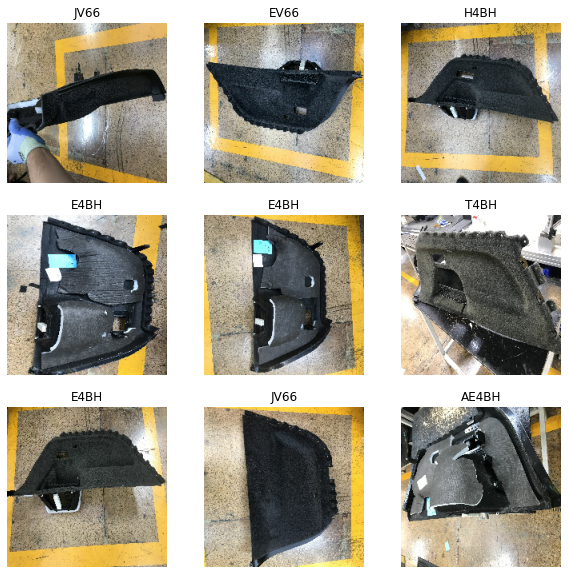

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 200, 200, 3)
(32,)
tf.Tensor(
[ 8  2  5  0  2  8 13 13  1  2  0  1  4  9 10  3 12  2  5  7  0  2  1 12
  3 12 12  2  0 11 10  9], shape=(32,), dtype=int32)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = tf.nn.softmax)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [16]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
4/4 [==============================] - 3s 610ms/step - loss: 2.6249 - accuracy: 0.1102 - val_loss: 2.6884 - val_accuracy: 0.0345
Epoch 2/50
4/4 [==============================] - 2s 466ms/step - loss: 2.5793 - accuracy: 0.2119 - val_loss: 2.6788 - val_accuracy: 0.0690
Epoch 3/50
4/4 [==============================] - 2s 434ms/step - loss: 2.5096 - accuracy: 0.2458 - val_loss: 2.6688 - val_accuracy: 0.0690
Epoch 4/50
4/4 [==============================] - 2s 502ms/step - loss: 2.4733 - accuracy: 0.2797 - val_loss: 2.6209 - val_accuracy: 0.1379
Epoch 5/50
4/4 [==============================] - 2s 507ms/step - loss: 2.4216 - accuracy: 0.3390 - val_loss: 2.6302 - val_accuracy: 0.1379
Epoch 6/50
4/4 [==============================] - 2s 483ms/step - loss: 2.4151 - accuracy: 0.3390 - val_loss: 2.6249 - val_accuracy: 0.1034
Epoch 7/50
4/4 [==============================] - 2s 421ms/step - loss: 2.4114 - accuracy: 0.3305 - val_loss: 2.6028 - val_accuracy: 0.1379
Epoch 8/50
4/4 [====

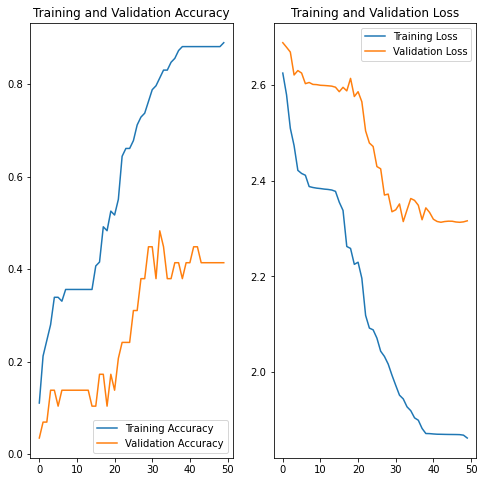

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
from tensorflow.keras.preprocessing import image

img_path = 'phev.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))

In [19]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

img_preprocessed = preprocess_input(img_batch)

In [22]:
prediction = model.predict(img_preprocessed)
print(prediction)

[[1.38888498e-10 1.15602825e-05 9.53791904e-23 4.64641438e-20
  0.00000000e+00 2.55206689e-10 8.73757684e-15 5.55874791e-13
  1.39938341e-32 8.28254989e-15 0.00000000e+00 8.04803115e-20
  1.55583305e-18 9.99988437e-01]]
